In [11]:
import os
import sys
import warnings

os.environ["CUDA_VISIBLE_DEVICES"] = "6"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
sys.path.append(os.getcwd())
sys.path.append("..")
warnings.filterwarnings("ignore")

import numpy as np
import matplotlib.pyplot as plt

# TF/Keras
import tensorflow as tf
from tensorflow import keras
from keras import backend as K

# Data



In [12]:

def make_timeseries_dataset(data, target, timesteps):
    #タイムステップ分ずらす
    N = len(target[timesteps:])
    X = np.zeros((N, timesteps, 1), np.float32)
    Y = np.zeros((N, 1), np.float32)
    for i in range(N):
        X[i] = data[i:i+timesteps][:,np.newaxis]
        Y[i] = target[i+timesteps]
    return X, Y

def make_dataset_for_stateful(data_list, target_list, timesteps):
    N = len(data_list)
    X = []
    Y = []
    for i in range(N):
        x, y = make_timeseries_dataset(data_list[i], target_list[i], timesteps)
        X.append(x)
        Y.append(y)
    X = np.concatenate(X, axis=(1)).reshape(-1, timesteps, 1)
    Y = np.concatenate(Y, axis=(1)).reshape(-1, 1)

    return X, Y

# Model

In [13]:
def build_encoder(input_shape, h_dim, z_dim, name="encoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    z_mean = keras.layers.Dense(z_dim, name="z_mean")(x)
    z_log_var = keras.layers.Dense(z_dim, name="z_log_var")(x)
    outputs = [z_mean, z_log_var]
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_prior(input_shape, h_dim, z_dim, name="prior"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs) 
    prior_mean = keras.layers.Dense(z_dim, name="prior_mean")(x)
    prior_log_var = keras.layers.Dense(z_dim, name="prior_log_var")(x)
    outputs = [prior_mean, prior_log_var]

    return keras.Model(inputs=inputs, outputs=outputs, name=name)

def build_decoder(input_shape, h_dim, x_dim, name="decoder"):
    inputs = keras.layers.Input(shape=input_shape)
    x = keras.layers.Dense(h_dim, activation="relu")(inputs)
    x = keras.layers.Dense(h_dim, activation="relu")(x)
    x = keras.layers.Dense(x_dim)(x)
    outputs = x
    
    return keras.Model(inputs=inputs, outputs=outputs, name=name)

class Sampling(keras.layers.Layer):
    def __init__(self, name="sampling"):
        super().__init__(name=name)
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [14]:
class VRNNCell(keras.layers.Layer):
    def __init__(self, h_dim, z_dim):
        super().__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.state_size = h_dim

    def build(self, input_shape):
        batch_size, x_dim = input_shape

        self.phi_x_layer = keras.Sequential([
            keras.layers.Input((x_dim)),
            keras.layers.Dense(self.h_dim, activation="relu"),
            keras.layers.Dense(self.h_dim, activation="relu")
        ])
        self.phi_z_layer = keras.layers.Dense(self.h_dim, activation="relu")
        self.encoder = build_encoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.prior_layer = build_prior(input_shape=(self.h_dim), h_dim=self.h_dim, z_dim=self.z_dim)
        self.decoder = build_decoder(input_shape=(self.h_dim+self.h_dim), h_dim=self.h_dim, x_dim=x_dim)

        self.rnn_cell = keras.layers.GRUCell(self.h_dim)

        self.sampling_layer = Sampling()

    def call(self, inputs, states):
        h = states[0]   # B x h_dim

        phi_x = self.phi_x_layer(inputs)    # B x h_dim
        x = keras.layers.Concatenate(axis=(1))([phi_x, h])  # B x h_dim+h_dim

        # encoder
        z_mean, z_log_var = self.encoder(x)     # B x z_dim, B x z_dim

        # prior
        prior_mean, prior_log_var = self.prior_layer(h)     # B x z_dim, B x z_dim

        # reparametrization trick
        z = self.sampling_layer([z_mean, z_log_var])    # B x z_dim

        phi_z = self.phi_z_layer(z)     # B x z_dim
        x = keras.layers.Concatenate(axis=(1))([phi_z, h])  # B x h_dim+h_dim

        #decoder
        y = self.decoder(x)   # B x z_dim

        #recurrence
        phi = keras.layers.Concatenate(axis=(1))([phi_x, phi_z])
        _, new_h = self.rnn_cell(phi, [h])    # B x h_dim

        outputs = [y, z_mean, z_log_var, prior_mean, prior_log_var]
        new_states = [new_h]    # 1 x B x h_dim
        return outputs, new_states

In [15]:
class VRNN(keras.Model):
    def __init__(self, input_shape, h_dim=100, z_dim=16, return_sequences=False, name="vrnn", *args, **kwargs):
        super().__init__(name=name, *args, **kwargs)
        self.cell = VRNNCell(h_dim=h_dim, z_dim=z_dim)
        self.axis = (1, 2) if return_sequences else (1)

        # build model
        inputs = keras.layers.Input(input_shape)
        x = keras.layers.RNN(self.cell, return_sequences=return_sequences)(inputs)
        outputs = x
        self.rnn = keras.Model(inputs=inputs, outputs=outputs)

    def call(self, inputs, training=False):
        return self.rnn(inputs)
    
    def compile(self, optimizer, loss, *args, **kwargs):
        super().compile(*args, **kwargs)

        self.optimizer = optimizer
        self.loss = loss

        # Tracker
        self.total_cost_tracker = keras.metrics.Mean(name="total_cost")
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.kl_tracker = keras.metrics.Mean(name="kl_divergence")

    @property
    def metrics(self):
        return [
            self.total_cost_tracker,
            self.loss_tracker,
            self.kl_tracker
        ]

    def train_step(self, data):
        x, y_true = data
        with tf.GradientTape() as tape:
            outputs = self.rnn(x)
            y_pred, z_mean, z_log_var, prior_mean, prior_log_var = outputs

            # loss
            loss = tf.reduce_mean(self.loss(y_true, y_pred))

            # KL-divergence
            term1 = prior_log_var - z_log_var
            term2 = (tf.exp(z_log_var) + tf.square(z_mean - prior_mean)) / (tf.exp(prior_log_var) + 1e-12)
            term3 = -1
            kl = tf.reduce_mean(tf.reduce_sum(0.5 * (term1 + term2 + term3), axis=self.axis))

            total_cost = loss + kl

        grads = tape.gradient(total_cost, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        # Update
        self.total_cost_tracker.update_state(total_cost)
        self.loss_tracker.update_state(loss)
        self.kl_tracker.update_state(kl)
        
        return {m.name: m.result() for m in self.metrics}

# サンプル

#  データの取得

In [16]:
import numpy as np
data_G = np.loadtxt('G_DOSE_10-5.csv', delimiter=',')
data_Q = np.loadtxt('Q_DOSE_10-5.csv', delimiter=',')
x = data_G[:700, :].reshape((8, 700))
y = data_Q.reshape((8, 700))

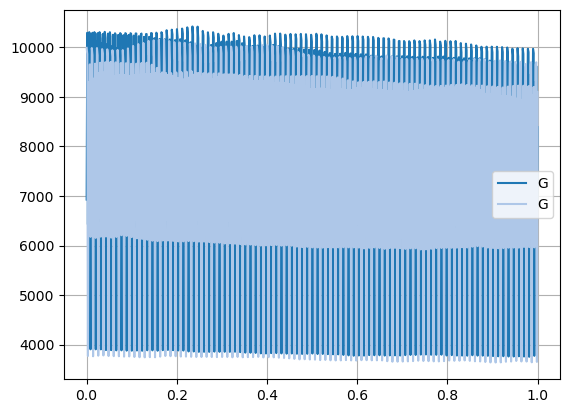

In [17]:
cmap = plt.get_cmap("tab20")

t = np.linspace(0, 1, 700)
# Check
plt.figure()
for i, (x_, y_) in enumerate(zip(x[:2, :], y)):
    plt.plot(t, x_, linestyle="-", color=cmap(i),label = "G")
    #plt.plot(t, y_, linestyle="--", color=cmap(i), label = "Q")
plt.legend()
plt.grid()
plt.show()

In [18]:
for i in range(8):
    x_ = x[i, :]
    x_max = np.amax(x_)
    x_min = np.amin(x_) 
    x_edit = x_/(x_max - x_min)
    x[i, :] = x_edit
    
    y_ = y[i, :]
    y_max = np.amax(y_)
    y_min = np.amin(y_) 
    y_edit = y_/(y_max - y_min)
    y[i, :] = y_edit

array([[ 0.23950589,  0.25169862,  0.2314415 , ...,  0.22973669,
         0.73155788, -0.13639991],
       [ 0.03906089, -0.01613904,  0.03891768, ..., -0.09790166,
        -0.08644656, -0.21215357],
       [-0.09456178, -0.15718874, -0.16989684, ..., -0.28895351,
         0.19614316, -0.01770259],
       ...,
       [ 0.19365036, -0.05907697,  0.24333349, ...,  0.05556849,
         0.19709938,  0.41043368],
       [ 0.1296129 ,  0.03070186,  0.16693056, ..., -0.06860589,
        -0.3007506 , -0.19961139],
       [-0.13233116, -0.08674881, -0.10114501, ...,  0.03619363,
        -0.06576594, -0.72029072]])

In [19]:
timesteps = 10

train_x, train_y = make_dataset_for_stateful(x, y, timesteps)

# モデルの取得

In [20]:
x_dim = 1
h_dim = 1000
z_dim = 4

model = VRNN(input_shape=(timesteps, x_dim), h_dim=h_dim, z_dim=z_dim)

# 学習


In [21]:
loss = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss)

hist = model.fit(
    train_x, train_y,
    batch_size=len(x),
    epochs=1
)

690/690 [==============================] - 287s 410ms/step - total_cost: 0.0666 - loss: 0.0627 - kl_divergence: 0.0039


# 推論

In [31]:
t = np.linspace(0, 700, 700)

x_ = x[7, :].reshape((1, 700))
y_ = y[7, :].reshape((1, 700))
test_x, _ = make_dataset_for_stateful(x_, y_, timesteps)

outputs = model(test_x)

pred_y = outputs[0]

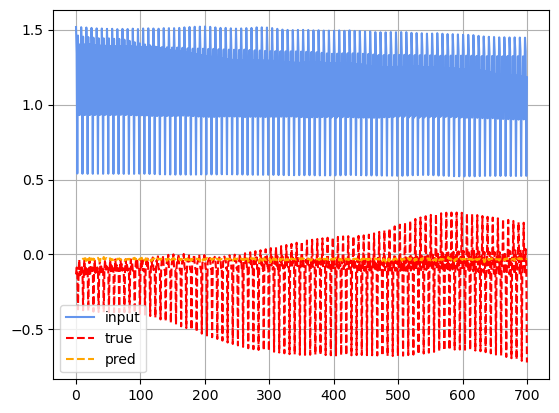

In [30]:
plt.figure()
plt.plot(t, np.squeeze(x_), linestyle="-", color="cornflowerblue", label="input")
plt.plot(t, np.squeeze(y_), linestyle="--", color="red", label="true")
plt.plot(t[timesteps:], np.squeeze(pred_y), linestyle="--", color="orange", label="pred")
plt.legend()
plt.grid()
plt.show()

In [25]:
model.summary()

Model: "vrnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vrnn_cell_1 (VRNNCell)      multiple                  17036017  
                                                                 
 model_1 (Functional)        [(None, 1),               17036017  
                              (None, 4),                         
                              (None, 4),                         
                              (None, 4),                         
                              (None, 4)]                         
                                                                 
Total params: 17,036,023
Trainable params: 17,036,017
Non-trainable params: 6
_________________________________________________________________
